# Lesson 1: Cats and Dogs

For this lesson, we'll be using a library called [pytorch-sconce](https://github.com/davidlmorton/pytorch-sconce) to make training and visualization a little easier.  With this library, you first create something called a [DataGenerator](https://davidlmorton.github.io/pytorch-sconce/data_generator.html#sconce.data_generators.DataGenerator) that will load our Cats and Dogs images from disk and get them ready to hand to the pytorch model for training.  Once we can load the data, its just a matter of wrapping the pytorch model in a model class that satisfies the [sconce model restrictions](https://davidlmorton.github.io/pytorch-sconce/models.html#module-sconce.models).  

## For Google Colab (Install pytorch-sconce first)

In [1]:
# change to True if you need to install dependencies
on_google_colab = False

if on_google_colab:
    !pip install --process-dependency-links pytorch-sconce==1.1.0
    !pip install --no-cache-dir -I Pillow==5.0.0
    # You may need to restart the notebook (Menubar: Runtime -> Restart runtime...)

## Imports

In [2]:
from sconce.data_generators import SingleClassImageDataGenerator
from sconce.models.base import Model
from sconce.schedules import Triangle
from sconce.trainers import SingleClassImageClassifierTrainer
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import os
import sconce
import torch
import torchvision

print(f"Run with pytorch-sconce version: {sconce.__version__}")

Run with pytorch-sconce version: 1.1.0


## Download cats and dogs data

In [3]:
if not os.path.exists('data'):
    !mkdir data && wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip -d data/
else:
    print("Data already downloaded, skipping...")

Data already downloaded, skipping...


## Define DataGenerators

With [sconce](https://github.com/davidlmorton/pytorch-sconce), you first create something called a [DataGenerator](https://davidlmorton.github.io/pytorch-sconce/data_generator.html#sconce.data_generators.DataGenerator) that will load our Cats and Dogs images from disk and get them ready to hand to the pytorch model for training.  The [SingleClassImageDataGenerator](https://davidlmorton.github.io/pytorch-sconce/data_generator.html#sconce.data_generators.SingleClassImageDataGenerator) will also give us a couple of handy methods to examine the dataset such as `plot_class_summary` and `plot_image_size_summary`

In [4]:
image_size = 224

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

loader_kwargs = {
    'batch_size': 256,
    'shuffle': True,
    'num_workers': 3  # this needs to be 0 for google colab
}

training_data_generator = SingleClassImageDataGenerator.from_image_folder(
    root='data/dogscats/train',
    transform=transform,
    loader_kwargs=loader_kwargs)

test_data_generator = SingleClassImageDataGenerator.from_image_folder(
    root='data/dogscats/valid',
    transform=transform,
    loader_kwargs=loader_kwargs)

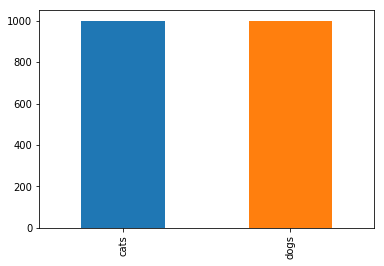

In [5]:
test_data_generator.plot_class_summary();

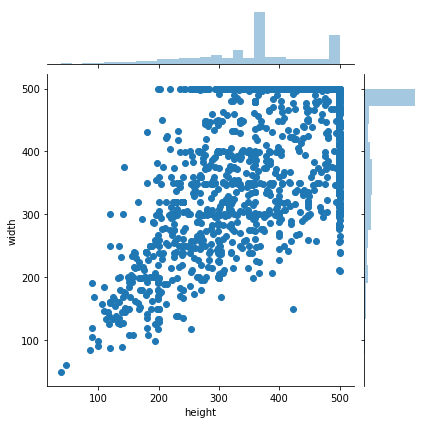

In [6]:
test_data_generator.plot_image_size_summary();

## Define Model

We need to wrap the pretrained pytorch [nn.Module](https://pytorch.org/docs/master/nn.html#torch.nn.Module) in a sconce [Model](FIXME).
The sconce model needs to have a pytorch [optimizer](http://pytorch.org/docs/master/optim.html#module-torch.optim), so it can make parameter updates during training, in this case we chose the [optim.Adam](https://pytorch.org/docs/master/optim.html#torch.optim.Adam) optimizer.
This will then let us construct a [Trainer](https://davidlmorton.github.io/pytorch-sconce/trainers.html#sconce.trainer.Trainer) object to train the model.

In [7]:
class MyModel(Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
    def forward(self, inputs, **kwargs):
        x = self.base_model(inputs)
        x = F.log_softmax(x, dim=1)
        return {'outputs': x}
    
    def calculate_loss(self, targets, outputs, **kwargs):
        return {'loss': F.nll_loss(input=outputs, target=targets)}

    def calculate_metrics(self, targets, outputs, **kwargs):
        y_out = np.argmax(outputs.cpu().data.numpy(), axis=1)
        y_in = targets.cpu().data.numpy()
        num_correct = (y_out - y_in == 0).sum()
        classification_accuracy = num_correct / len(y_in)
        return {'classification_accuracy': classification_accuracy}
    
def create_model(model_class=MyModel):
    # Get a resnet model pretrained on imagenet data (will download training weights).
    base_model = torchvision.models.resnet18(pretrained=True)
    
    # Freeze all layers, so they don't get updated during training.
    for param in base_model.parameters():
        param.requires_grad = False
        
    # Replace last fully-connected layer with one that outputs only two categories (cat / dog).
    # This is now the only layer that isn't yet trained.
    base_model.fc = nn.Linear(in_features=base_model.fc.in_features, out_features=2)
    
    model = model_class(base_model)
    
    # attach an optimzier to the active parameter groups
    model.set_optimizer(optim.SGD, lr=1e-1, momentum=0.9)
    
    return model

In [8]:
model = create_model()

if torch.cuda.is_available():
    model.cuda()
    training_data_generator.cuda()
    test_data_generator.cuda()

## Construct Trainer

Then with the model and the data generators we already made above we're ready to instantiate the trainer.
Here we instantiate a [ClassifierTrainer](https://davidlmorton.github.io/pytorch-sconce/sconce.trainers.html#module-sconce.trainers.classifier_trainer) so that we get a couple of handy methods, such as `get_classification_accuracy` and `plot_samples`.

In [9]:
trainer = SingleClassImageClassifierTrainer(model=model,
    training_data_generator=training_data_generator,
    test_data_generator=test_data_generator)

## Survey for a Learning Rate

The learning rate is an important hyperparameter to get right, but knowing what values to try can be hard to figure out.  [This blog post](https://medium.com/@davidlmorton/exploring-the-learning-rate-survey-3e328d17cf79) introduces the learning rate survey that [pytorch-sconce](https://github.com/davidlmorton/pytorch-sconce) implements, and goes into some detail about how it can be used to help find a good range of learning rates for a given model and dataset.

In [10]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=0.5,
    min_learning_rate=1e-5,
    max_learning_rate=10,
    stop_factor=10)

37/45 [=======================>......] - ETA: 3s - loss: 0.4395
Scheduled training termination: Exponential Schedule stop condition met.


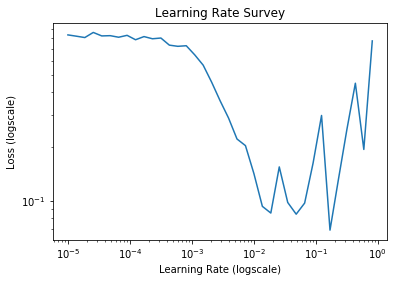

In [11]:
survey_monitor.dataframe_monitor.plot_learning_rate_survey()

## Train Model

To change the learning rate during training we can set a [Schedule](FIXME).

In [12]:
trainer.model.set_schedule('learning_rate', Triangle(initial_value=2e-3, peak_value=1e-2))
trainer.train(num_epochs=1);

90/90 [==============================] - 40s 443ms/step - loss: 0.0765 - val_loss: 0.0738


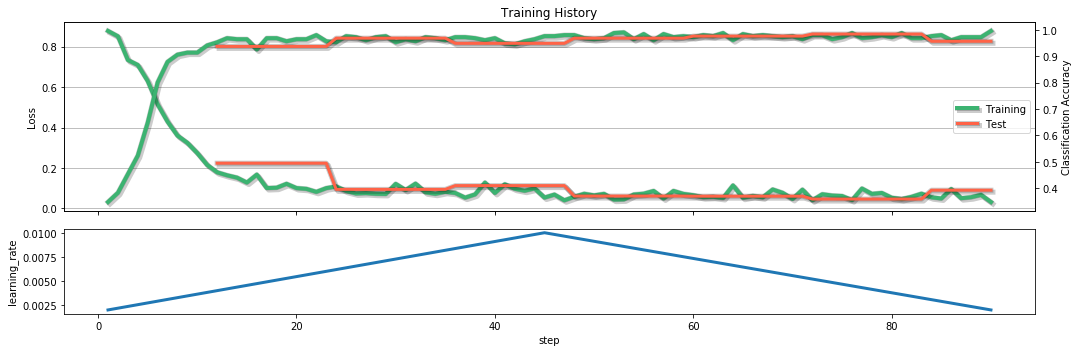

In [13]:
trainer.monitor.dataframe_monitor.plot(
    skip_first=0,
    smooth_window=1,
    metrics=['loss', 'classification_accuracy']);

## Evaluate Model Predictions 

In [14]:
trainer.get_classification_accuracy()

0.975

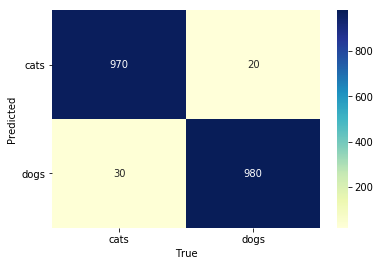

In [15]:
trainer.plot_confusion_matrix();

Misclassified as Dogs
Showing only the first 7 of 30 images


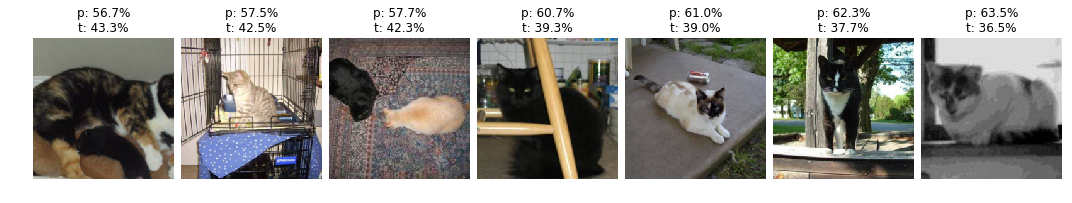

In [16]:
print("Misclassified as Dogs")
trainer.plot_samples(predicted_class='dogs', true_class='cats');

Misclassified as Cats
Showing only the first 7 of 20 images


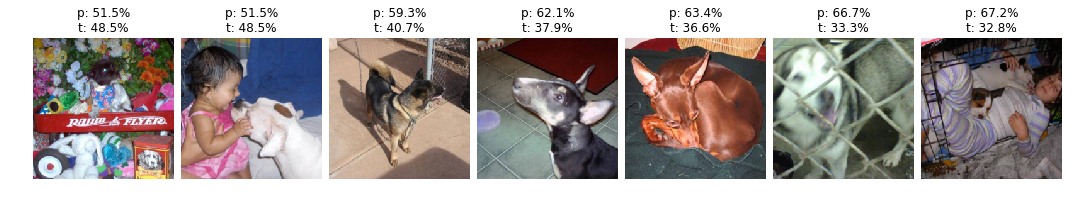

In [17]:
print("Misclassified as Cats")
trainer.plot_samples(predicted_class='cats', true_class='dogs');

Most Dog-like Dogs
Showing only the first 7 of 980 images


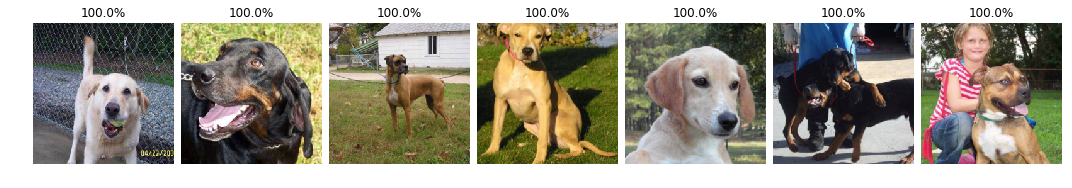

In [18]:
print("Most Dog-like Dogs")
trainer.plot_samples(predicted_class='dogs', true_class='dogs', sort_by='falling predicted class score');

Most Cat-like Cats
Showing only the first 7 of 970 images


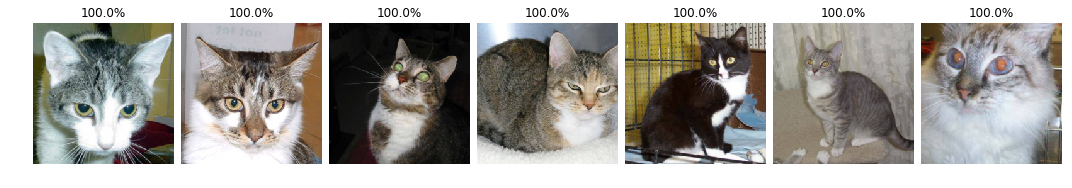

In [19]:
print("Most Cat-like Cats")
trainer.plot_samples(predicted_class='cats', true_class='cats', sort_by='falling predicted class score');

## Layerwise Learning Rates

Now, instead of just training the final fully connected layer, we could have also trained all or part of the pretrained base model.  It turns out that fine tuning (retraining) the last set of convolutional layers of the base model will allow us to achieve a better classification accuracy than just training the final fully connected layer.  First we plot the summary of the model and then start "unfreezing" the part of it that we want to fine tune.

In [20]:
from sconce.parameter_group import ParameterGroup

class MyLayerWiseModel(MyModel):
    def build_parameter_groups(self):
        super().build_parameter_groups()
        mid_layer_parameters = (list(self.base_model.layer4.parameters()) +
                                list(self.base_model.layer3.parameters()))
        mid_layer_group = ParameterGroup(parameters=mid_layer_parameters, name='mid_layer')
        mid_layer_group.unfreeze()
        self.add_parameter_group(mid_layer_group)
        
        fc_parameters = list(self.base_model.fc.parameters())
        fc_group = ParameterGroup(parameters=fc_parameters, name='fc')
        self.add_parameter_group(fc_group)
        
model = create_model(model_class=MyLayerWiseModel)
model.cuda();

In [21]:
trainer = SingleClassImageClassifierTrainer(model=model,
    training_data_generator=training_data_generator,
    test_data_generator=test_data_generator)

32/45 [====================>.........] - ETA: 7s - loss: 0.3891
Scheduled training termination: Exponential Schedule stop condition met.


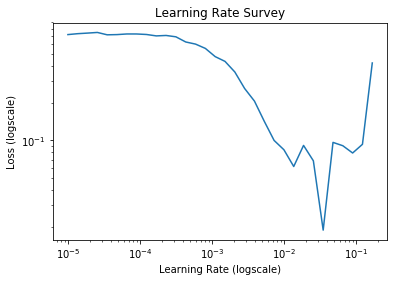

In [22]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=0.5,
    min_learning_rate=1e-5,
    max_learning_rate=10,
    stop_factor=10)
survey_monitor.dataframe_monitor.plot_learning_rate_survey();

180/180 [==============================] - 118s 658ms/step - loss: 0.0436 - val_loss: 0.0436


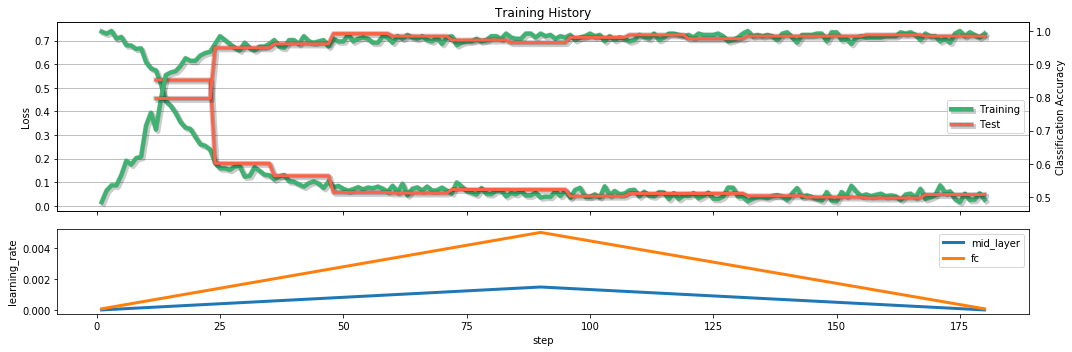

In [24]:
peak_rate = 5e-3
initial_rate = 1e-4
decay_factor = 0.3
trainer.model.get_parameter_group('fc').set_schedule(
    'learning_rate', Triangle(initial_value=initial_rate, peak_value=peak_rate))
trainer.model.get_parameter_group('mid_layer').set_schedule(
    'learning_rate', Triangle(initial_value=initial_rate * decay_factor, peak_value=peak_rate * decay_factor))
trainer.train(num_epochs=2)

trainer.monitor.dataframe_monitor.plot(
    skip_first=0,
    smooth_window=1,
    metrics=['loss', 'classification_accuracy']);

In [25]:
trainer.get_classification_accuracy()

0.9845

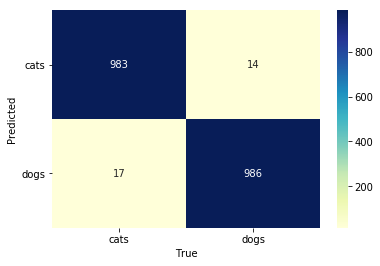

In [26]:
trainer.plot_confusion_matrix();

Misclassified as Dogs
Showing only the first 7 of 17 images


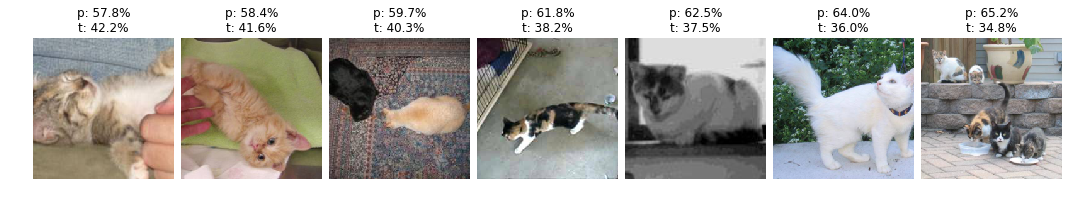

In [27]:
print("Misclassified as Dogs")
trainer.plot_samples(predicted_class='dogs', true_class='cats');

Misclassified as Cats
Showing only the first 7 of 14 images


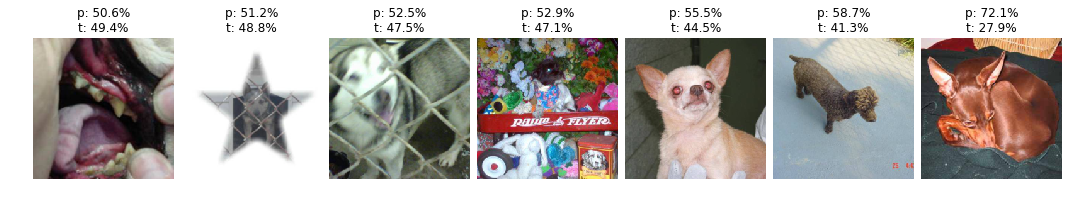

In [28]:
print("Misclassified as Cats")
trainer.plot_samples(predicted_class='cats', true_class='dogs');